In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import matplotlib.style
import matplotlib as mpl
import scipy
import glob
import re
from matplotlib.pyplot import cm
# mpl.style.use('classic')



plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['font.size'] = 18

In [4]:
E1 = 1000
nu1 = 0.4
E2 = 1e30
nu2 = 0.4
Es = E1 * E2 / ((1 - nu1*nu1) * E2 + (1 - nu2*nu2) * E1)
d = 0.005
l = 2.0
print("Es", Es)
print("ps", np.pi * Es * d / l)

Es 1190.4761904761906
ps 9.34997813568391


In [7]:
workdir = "/Users/ashvarts/mofem_install/um_release/build/basic_finite_elements/simple_contact/test_rough/wave_2d"
os.chdir(workdir)
file_list = glob.glob('test*.csv')
file_list.sort(key=lambda f: int(re.sub('\D', '', f)))
# print(file_list)

colors=cm.jet(np.linspace(0, 1, len(file_list)))

E1 = 1000
nu1 = 0.4
E2 = 1e30
nu2 = 0.4
Es = E1 * E2 / ((1 - nu1*nu1) * E2 + (1 - nu2*nu2) * E1)
d = 0.005
l = 2.0
p_max = 9.35
print("ps", np.pi * Es * d / l)
R = 10.0
a = pow(3.0 * p_max * R / 4.0 / Es, 1.0/3.0)
# print(a)

ps 9.34997813568391


In [58]:
def west_area(p0, Es, d, l):
    ps = np.pi * Es * d / l
    if p0 < ps:
        a = l / np.pi * np.arcsin(np.sqrt(p0 / ps))
    else:
        a = l/2
    return a

def sqr(x):
    return x * x

def west_press(x, p0, Es, d, l):
    a = west_area(p0, Es, d, l)
    psi_x = np.pi * x / l
    psi_a = np.pi * a / l
    if x < a: 
        p = 2.0 * np.pi * Es * d / l * np.cos(psi_x) * np.sqrt(sqr(np.sin(psi_a)) - sqr(np.sin(psi_x)))
    else:
        p = 0
    return p

def find_vert_disp_const_west(p0, Es, d, l):
    a = west_area(p0, Es, d, l)
    psi_a = np.pi * a / l
    sin2_a = sqr(np.sin(psi_a))
    C = -p0 * l / np.pi / Es / sin2_a
    return C

def west_norm_disp(x, p0, Es, d, l):
    a = west_area(p0, Es, d, l)
    psi_x = np.pi * x / l
    psi_a = np.pi * a / l
    sin_x = np.sin(psi_x)
    sin_a = np.sin(psi_a)
    sin2_x = sqr(np.sin(psi_x))
    sin2_a = sqr(np.sin(psi_a))
    C = find_vert_disp_const_west(p0, Es, d, l)
    if x < a:
        disp = p0 * l / np.pi / Es / sin2_a * np.cos(2.0 * psi_x) + C
    else:
        disp = p0 * l / np.pi / Es / sin2_a * (np.cos(2.0 * psi_x) + 2.0 * sin_x * np.sqrt(sin2_x - sin2_a) - 2.0 * sin2_a * np.log((sin_x + np.sqrt(sin2_x - sin2_a))/sin_a)) + C
    return disp

def west_tang_disp(x, p0, Es, nu, d, l):
    a = west_area(p0, Es, d, l)
    psi_x = np.pi * x / l
    psi_a = np.pi * a / l
    sin_x = np.sin(psi_x)
    sin_a = np.sin(psi_a)
    sin2_x = sqr(np.sin(psi_x))
    sin2_a = sqr(np.sin(psi_a))
    R = l**2 / (4. * np.pi**2 * d)
    k = 3. - 4. * nu1
    # if x < a:
    #     disp = l**2 / (2. * np.pi**2 * R) * (sin2_a * np.arcsin(sin_x / sin_a) - (k - 1.) / (k + 1.) * sin_x * np.sqrt(sin2_a - sin2_x))
    # else:
    #     disp = 0 
    # return disp

    k = 3.0 - 4.0 * nu
    
    sa = np.sin(np.pi * a / l) 
    sx = np.sin(np.pi * (x - l/ 2.) / l)

    sa2 = sqr(sa)
    sx2 = sqr(sx)
    if x - l / 2. < a and x - l / 2 > -a :
        #return -2.0 * d *  (sa2 * arcsin(sx / sa) - (k - 1.0) / (k + 1.0) * sx * sqrt(sa2 - sx2))
        return -d * (1 - 2 * nu) / (1 - nu) * (sx * np.sqrt(sa2 - sx2) + sa2 * np.arcsin(sx / sa))
    else:
        return 0. #d * sa2

def hertz_press_2d(x, P, Es, R):
    a = np.sqrt(4.0 * P * R / np.pi / Es)
    if x < a:
        p = 2.0 * P / np.pi / (a * a) * np.sqrt(a*a - x*x)
    else:
        p = 0
    return p

def hertz_press_3d(r, P, Es, R):
    a = pow(3.0 * P * R / 4.0 / Es, 1.0/3.0)
    p0 = 3.0 * P / (2.0 * np.pi * a * a)
    if r < a:
        p = p0 * np.sqrt(1 - r*r/a/a)
    else:
        p = 0
    return p

def find_norm_disp_const_hertz_3d(r, P, Es, R):
    a = pow(3.0 * P * R / 4.0 / Es, 1.0/3.0)
    p0 = 3.0 * P / (2.0 * np.pi * a * a)
    C = -np.pi * p0 * a / (2.0 * Es)
    return C


def hertz_norm_disp_3d(r, P, E, nu, R):
    Es = E / (1 - nu*nu)
    a = pow(3.0 * P * R / 4.0 / Es, 1.0/3.0)
    p0 = 3.0 * P / (2.0 * np.pi * a * a)
    C = find_norm_disp_const_hertz_3d(r, P, Es, R)
    # print(C)
    if r < a:
        w = np.pi * p0 / (4. * a * Es) * (2. * a**2  - r**2) + C
    else:
        w = p0 / (2. * a * Es) * ( (2. * a**2  - r**2) * np.arcsin(a/r) + r * a * np.sqrt(1. - a**2 / r**2) ) + C
    return -w

def hertz_tang_disp_3d(r, P, E, nu, R):
    Es = E / (1 - nu*nu)
    a = pow(3.0 * P * R / 4.0 / Es, 1.0/3.0)
    p0 = 3.0 * P / (2.0 * np.pi * a * a)
    if abs(r) < 1e-12:
        return 0
    if r < a:
        u = -(1. - 2.*nu) * (1. + nu) / (3. * E) * a**2 / r * p0 * (1. - pow(1. - r**2/a**2, 1.5))
    else:
        u = -(1. - 2.*nu) * (1. + nu) / (3. * E) * a**2 / r * p0 
    return u


def get_data_and_dict(file):
    with open(file) as f:
        first_line = f.readline().rstrip('\n')
        header = [x.strip('\"') for x in first_line.split(',')]
    my_dict = {}
    for s, i in zip(header, np.arange(len(header))):
        my_dict[s] = i
        # print(s, i)
    data = np.genfromtxt(file, delimiter=',', skip_header=1)
    data = data[data[:, my_dict["MESH_NODE_POSITIONS:0"]].argsort()]
    return data, my_dict

Text(0, 0.5, 'Normal displacement [mm]')

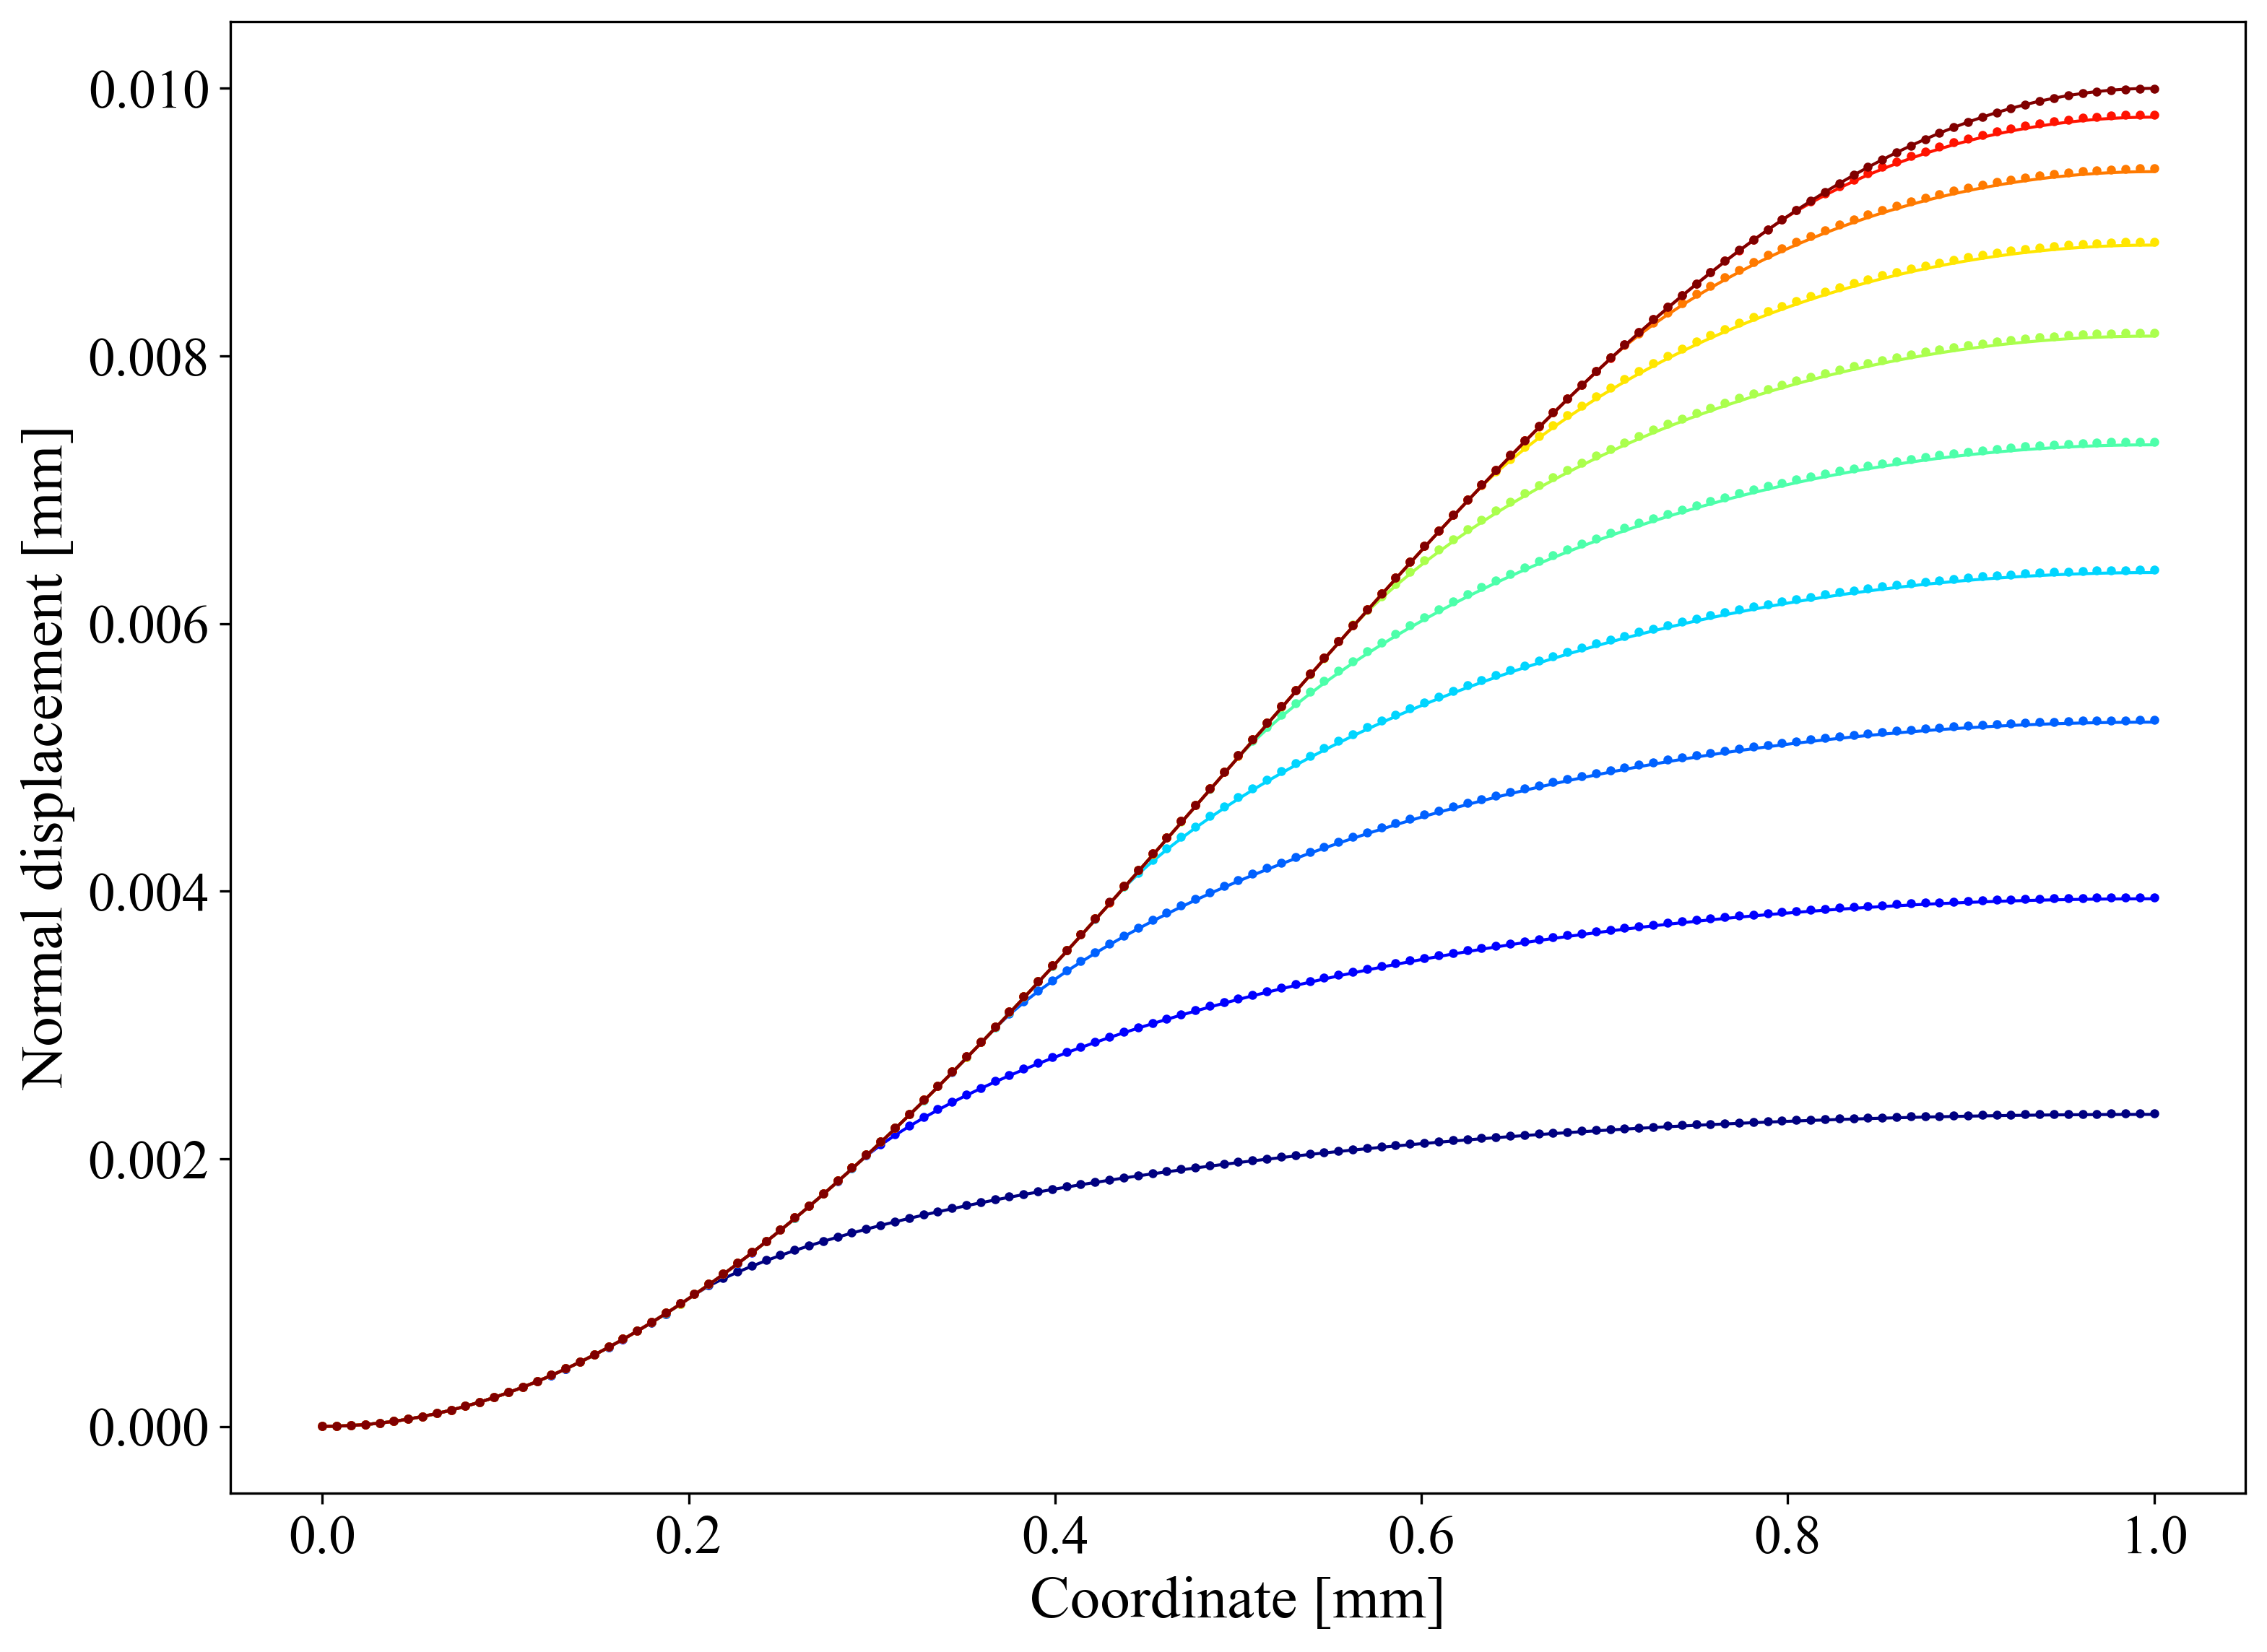

In [49]:
for file, c, m in zip(file_list, colors, np.arange(len(file_list))):
    data, my_dict = get_data_and_dict(file)
    X = data[:, my_dict["MESH_NODE_POSITIONS:0"]]
    Z = data[:, my_dict["MESH_NODE_POSITIONS:2"]]
    x = data[:, my_dict["SPATIAL_POSITION:0"]]
    z = data[:, my_dict["SPATIAL_POSITION:2"]]
    u = x - X
    w = z - Z
    p = p_max * (m + 1) / len(file_list)

    plt.plot(X, w, ls = 'None', lw = 1, marker='o', ms = 2, c=c, label = 'Numerical $w(x)$')
    vfunc = np.vectorize(west_norm_disp, otypes=[float])
    plt.plot(X, -vfunc(X, p, Es, d, l), ls = '-', lw = 1, c=c)

# plt.grid(color='grey', linestyle=':', linewidth=1)
plt.xlabel("Coordinate [mm]", fontsize=20)
plt.ylabel("Normal displacement [mm]", fontsize=20)
# plt.xlim(0, 0.125)
# plt.ylim(0, 4.5e-4 )
# plt.legend()
# plt.savefig('normal_disp.pdf')

Text(0, 0.5, 'Tangential displacement [mm]')

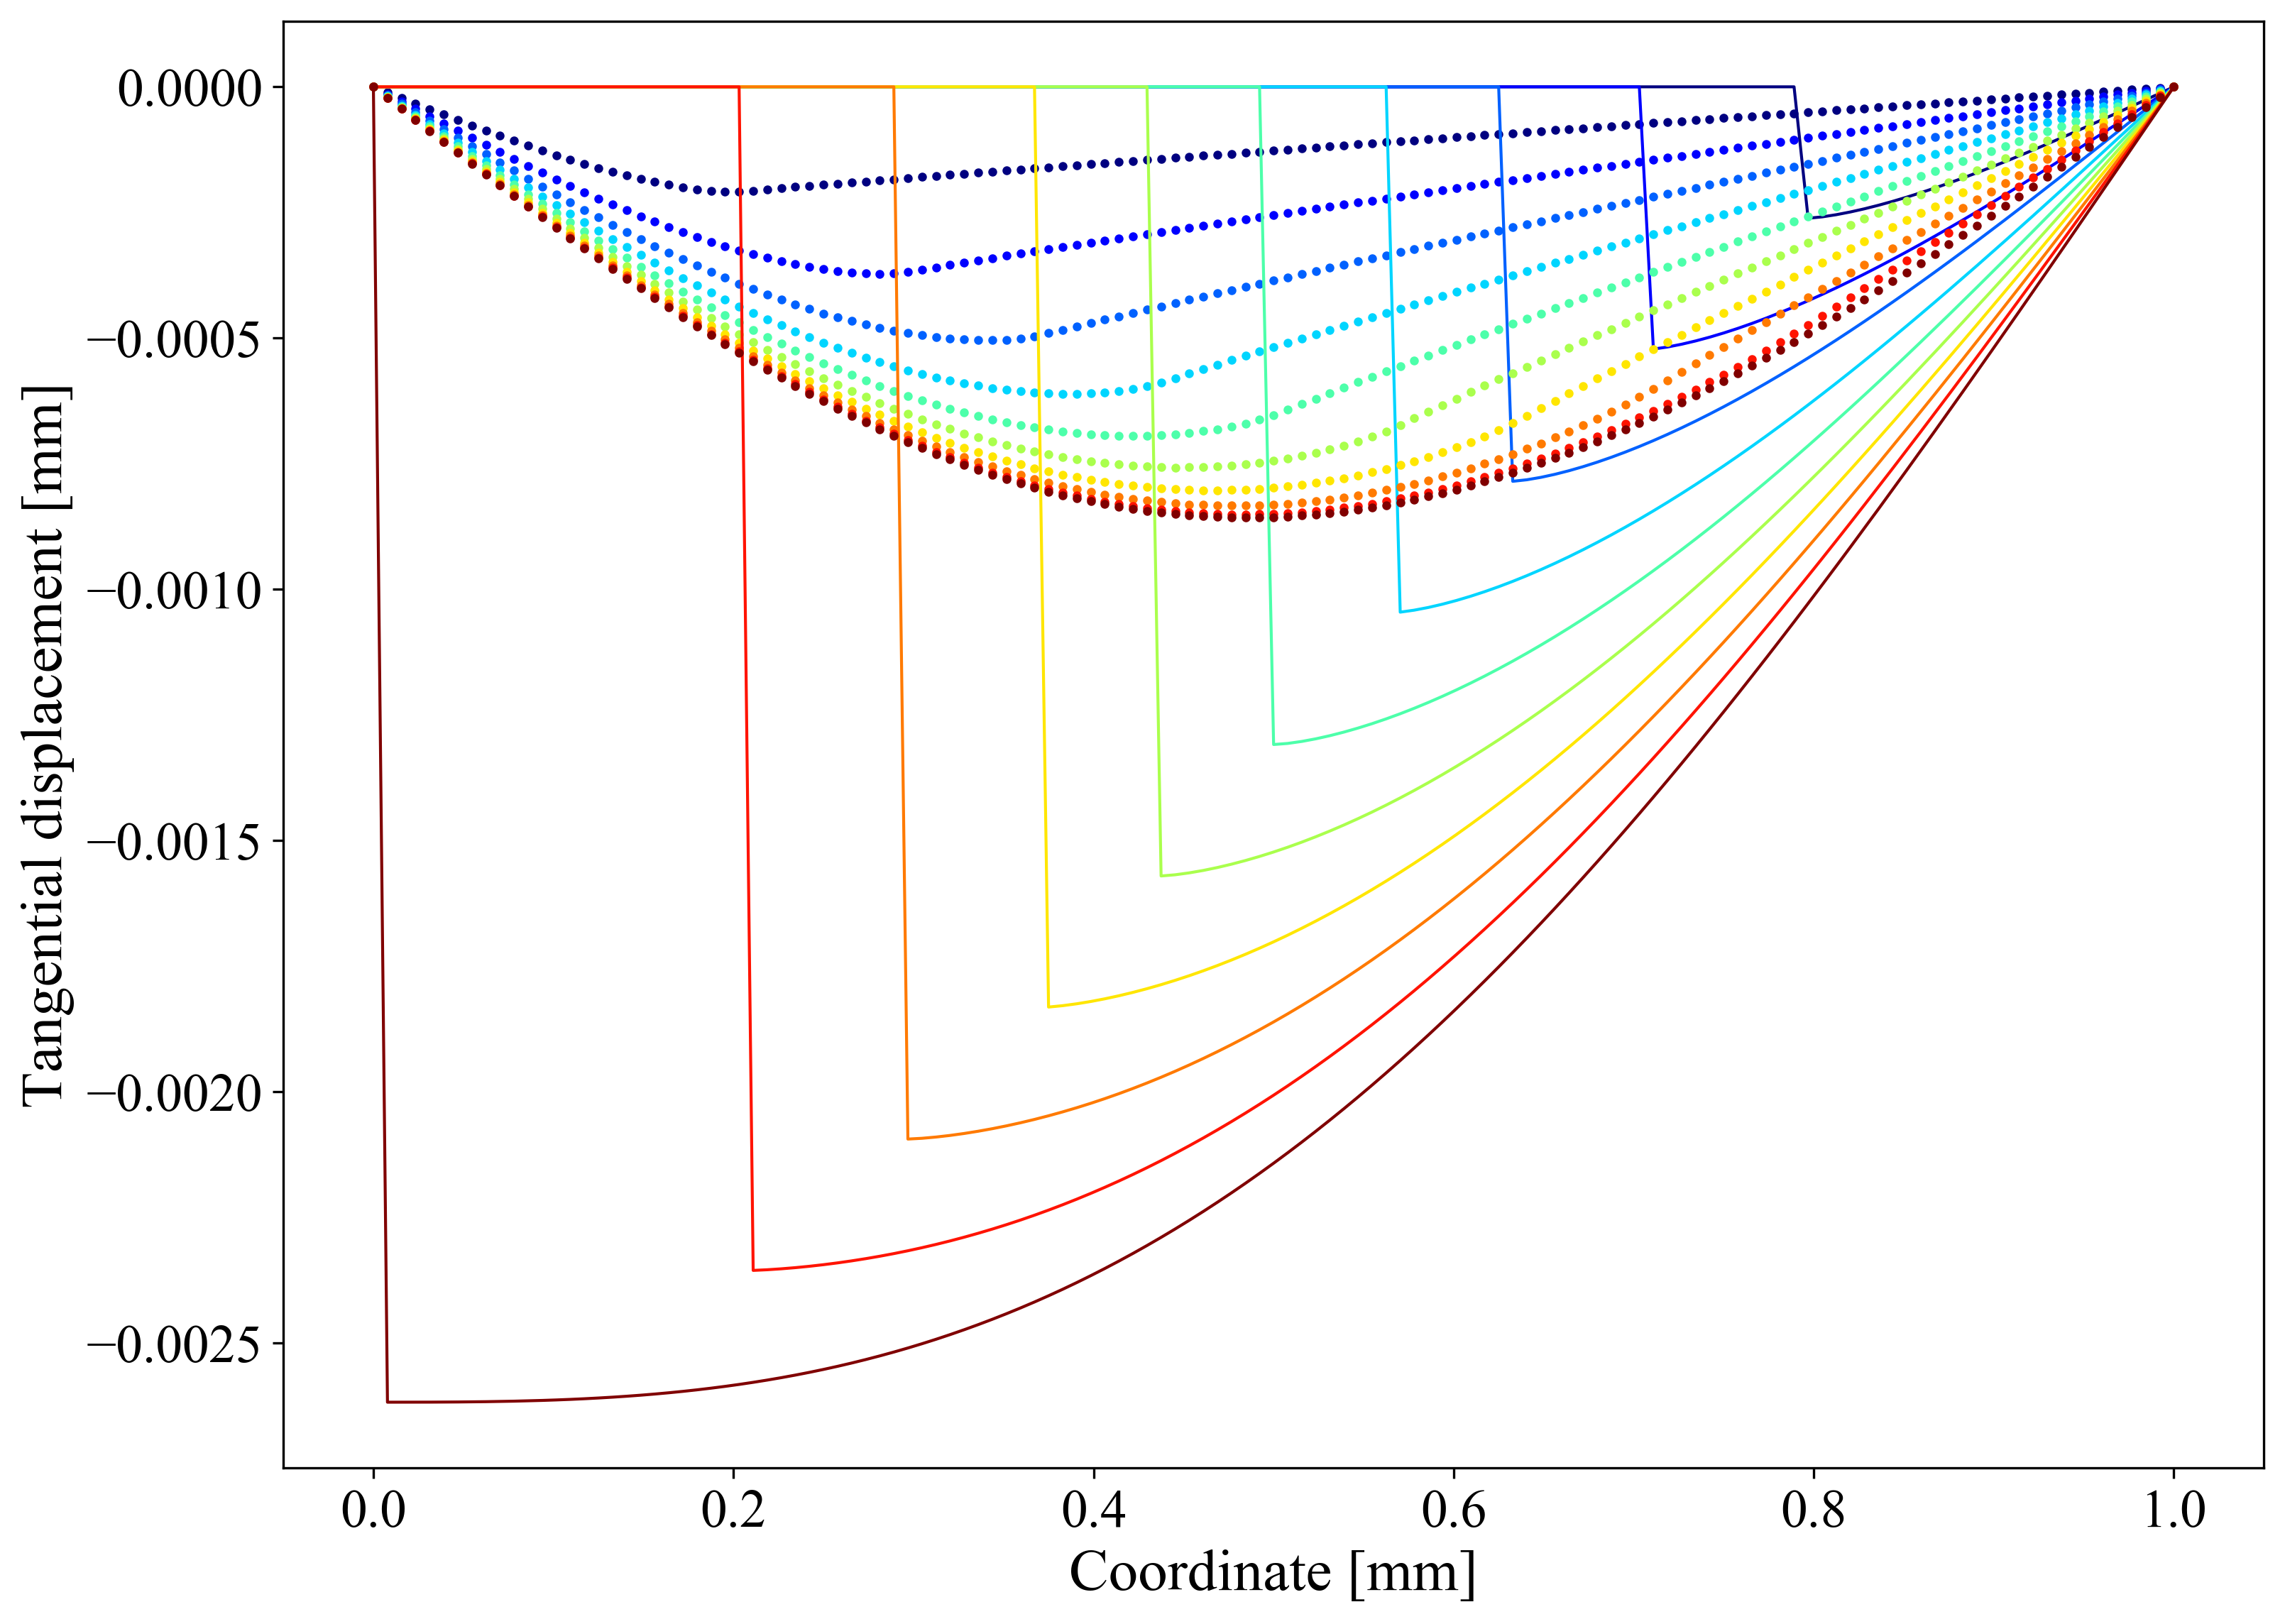

In [59]:

for file, c, m in zip(file_list, colors, np.arange(len(file_list))):
    data, my_dict = get_data_and_dict(file)
    X = data[:, my_dict["MESH_NODE_POSITIONS:0"]]
    Z = data[:, my_dict["MESH_NODE_POSITIONS:2"]]
    x = data[:, my_dict["SPATIAL_POSITION:0"]]
    z = data[:, my_dict["SPATIAL_POSITION:2"]]
    u = x - X
    w = z - Z
    p = p_max * (m + 1) / len(file_list)

    plt.plot(X, u, ls = 'None', lw = 1, marker='o', ms = 2, c=c, label = 'Numerical $w(x)$')
    vfunc = np.vectorize(west_tang_disp, otypes=[float])
    plt.plot(X, vfunc(X, p, Es, nu1, d, l), ls = '-', lw = 1, c=c)

# plt.grid(color='grey', linestyle=':', linewidth=1)
plt.xlabel("Coordinate [mm]", fontsize=20)
plt.ylabel("Tangential displacement [mm]", fontsize=20)
# plt.xlim(0, 0.125)
# plt.ylim(-6e-5, 0.0)
# plt.legend()
# plt.savefig('tangent_disp.pdf')

Text(0, 0.5, 'Contact pressure [MPa]')

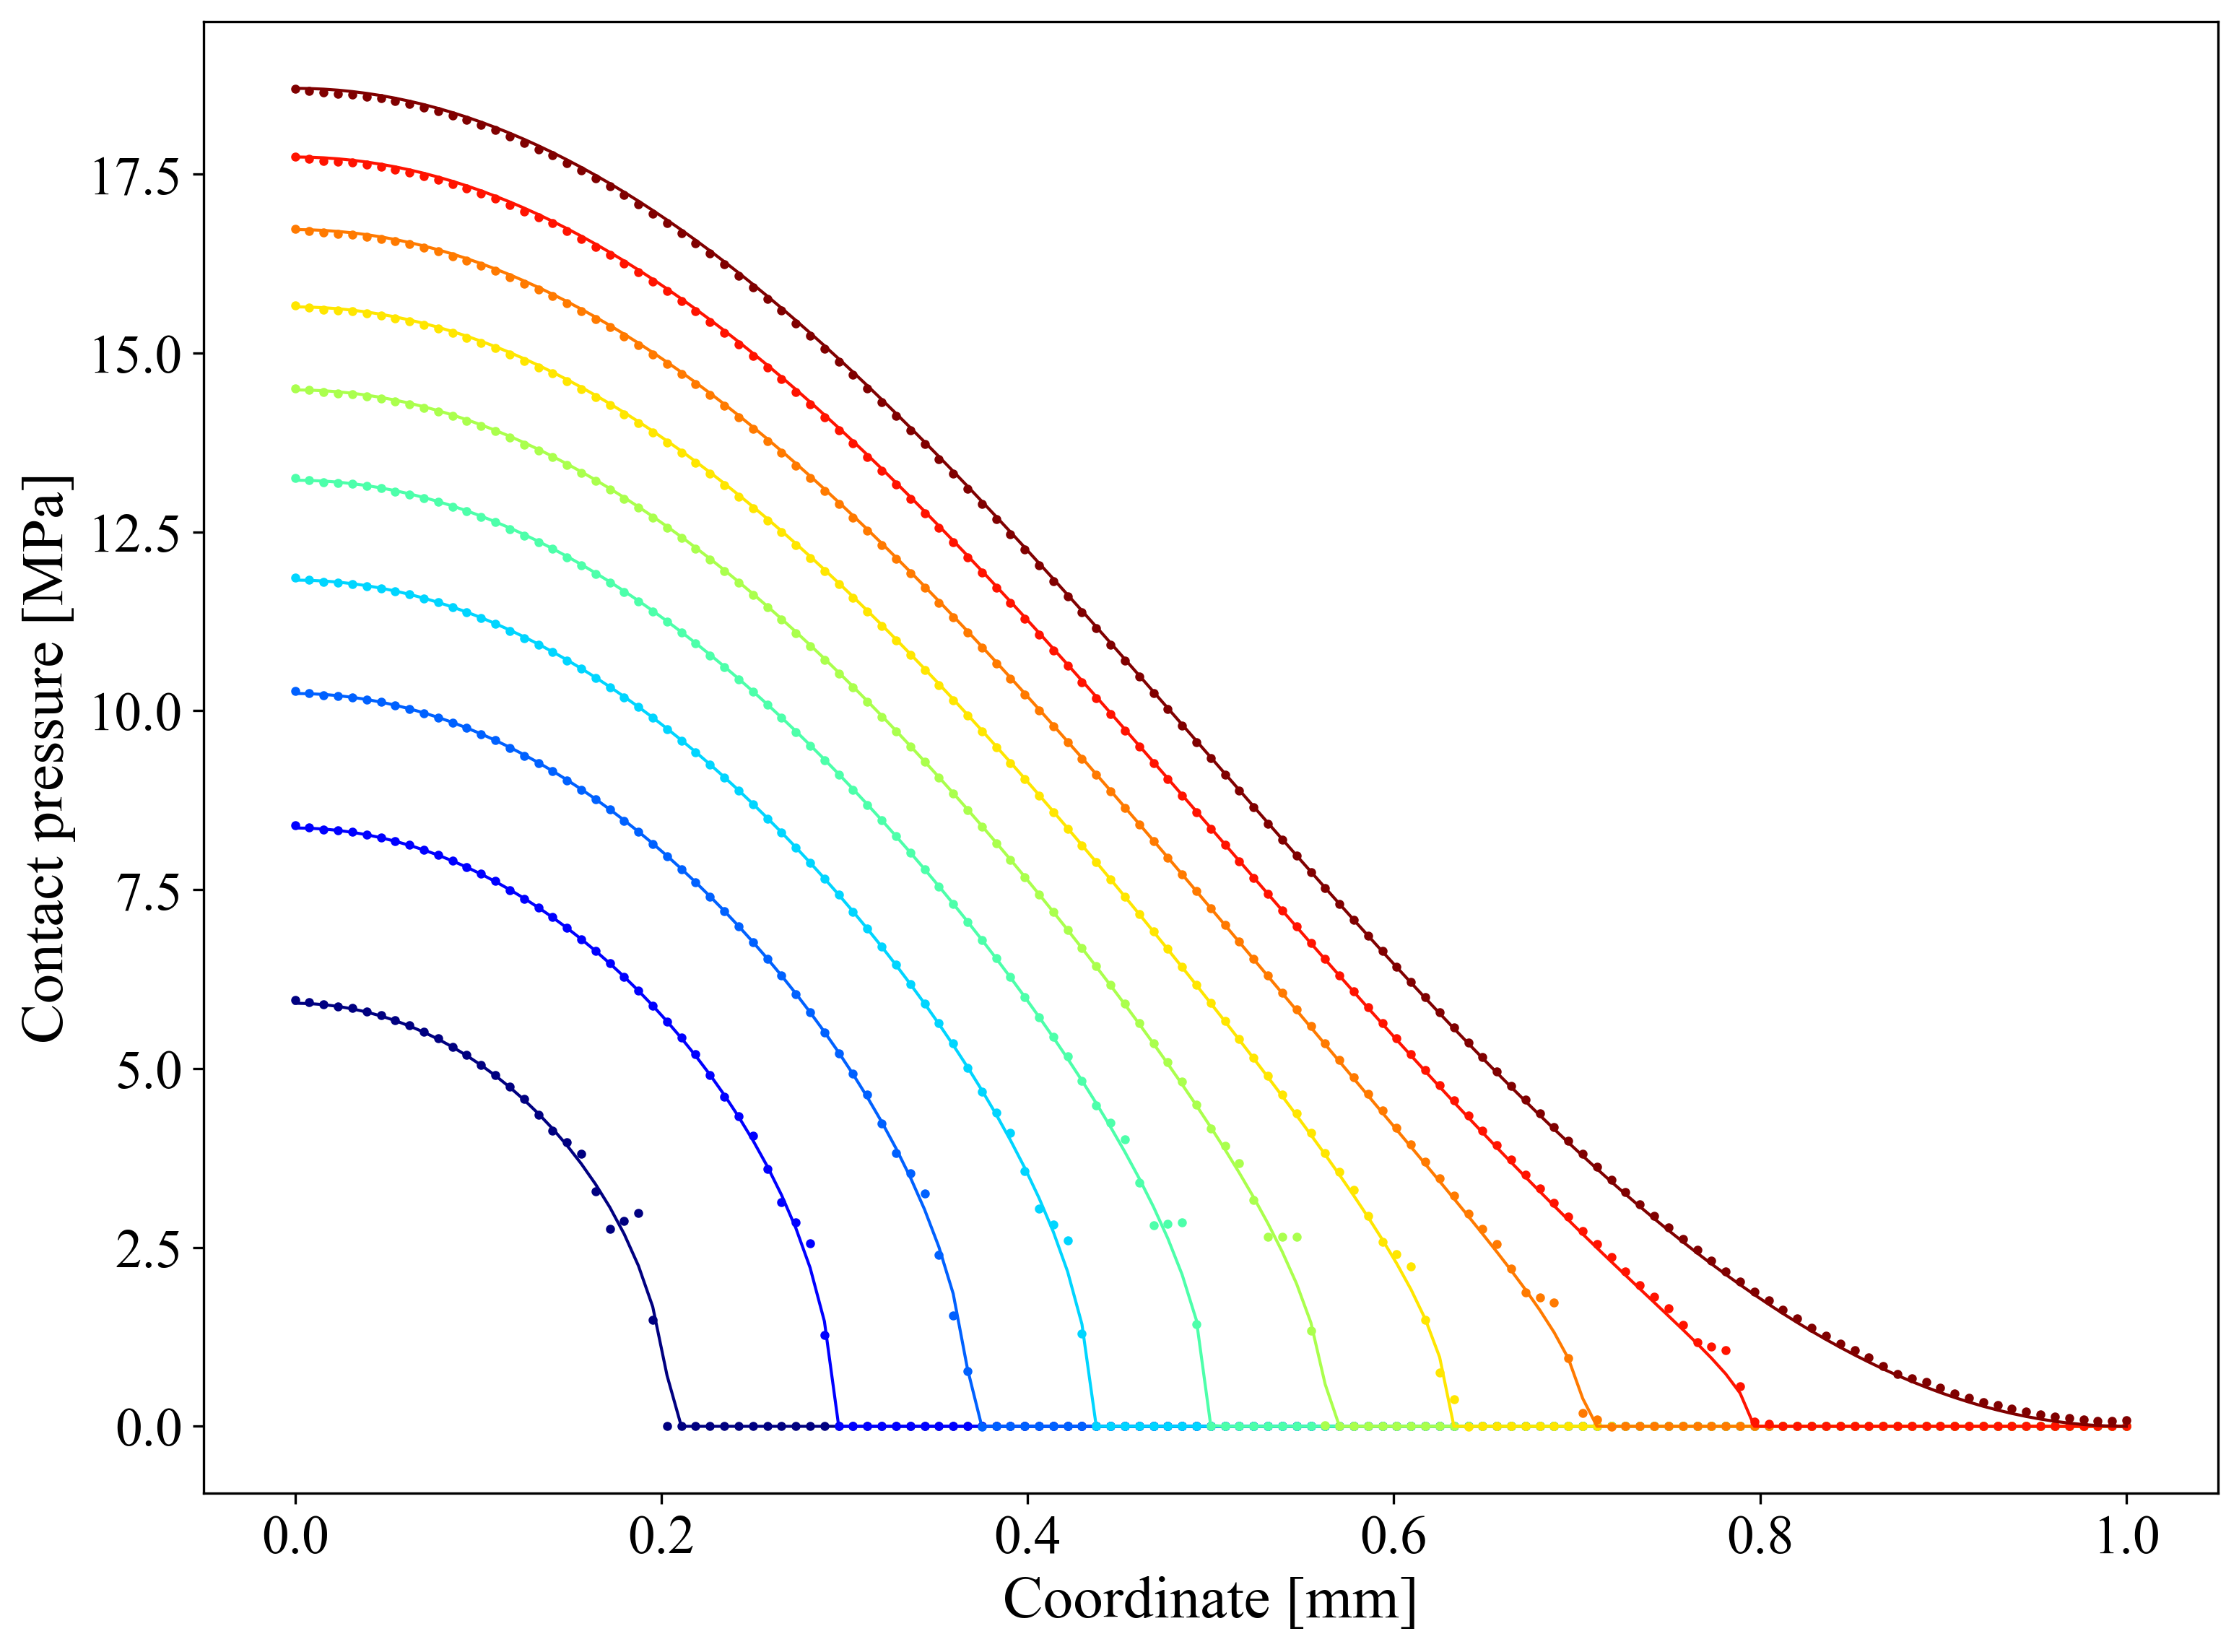

In [24]:
for file, c, m in zip(file_list, colors, np.arange(len(file_list))):
    data, my_dict = get_data_and_dict(file)
    X = data[:, my_dict["MESH_NODE_POSITIONS:0"]]
    L = data[:, my_dict["LAGMULT"]]
    p = p_max * (m + 1) / len(file_list)
    # P = p 
    # print(P)
    
    plt.plot(X, L, ls = 'None', lw = 1, c=c, marker='o', ms = 2, label = 'Numerical $\lambda(x)$')
    vfunc = np.vectorize(west_press)
    plt.plot(X, vfunc(X, p, Es, d, l), ls = '-', lw = 1, c=c)

#plt.grid(color='grey', linestyle=':', linewidth=1)
plt.xlabel("Coordinate [mm]", fontsize=20)
plt.ylabel("Contact pressure [MPa]", fontsize=20)
# plt.xlim(0, 0.085)
# plt.ylim(0, 7.5)
# plt.legend()
# plt.savefig('pressure.svg')

In [277]:
p = 0.001
a = 1
P = p * a * 2
anal_x = np.arange(0, 2, 0.001)
nu = 0.4
E = 1.0
anal_p = P / np.pi / np.sqrt(a*a - pow(anal_x, 2)) 
anal_u = -(1.0 - 2.0*nu)*(1.0 + nu)*P/(np.pi*E)*np.arcsin(anal_x/a)
i = 0
for xi in anal_x:
    if xi > a:
        anal_u[i] = -(1.0 - 2.0*nu)*(1.0 + nu)*P/(2.0*E)
    i += 1

/Users/ashvarts/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/Users/ashvarts/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys
/Users/ashvarts/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in arcsin
  


In [264]:
p = 0.001
a = 1
P = p * a * 2
anal_x = np.arange(0, 2, 0.001)
nu = 0.4
E = 1.0
w0 = data_w[0]
anal_w = w0 + 2*(1-nu*nu)*P / (np.pi * E) * np.log(anal_x/a + np.sqrt(pow(anal_x/a, 2) - 1))
i = 0
for xi in anal_x:
    if xi <= a:
        anal_w[i] = w0
    i += 1
    

/Users/ashvarts/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


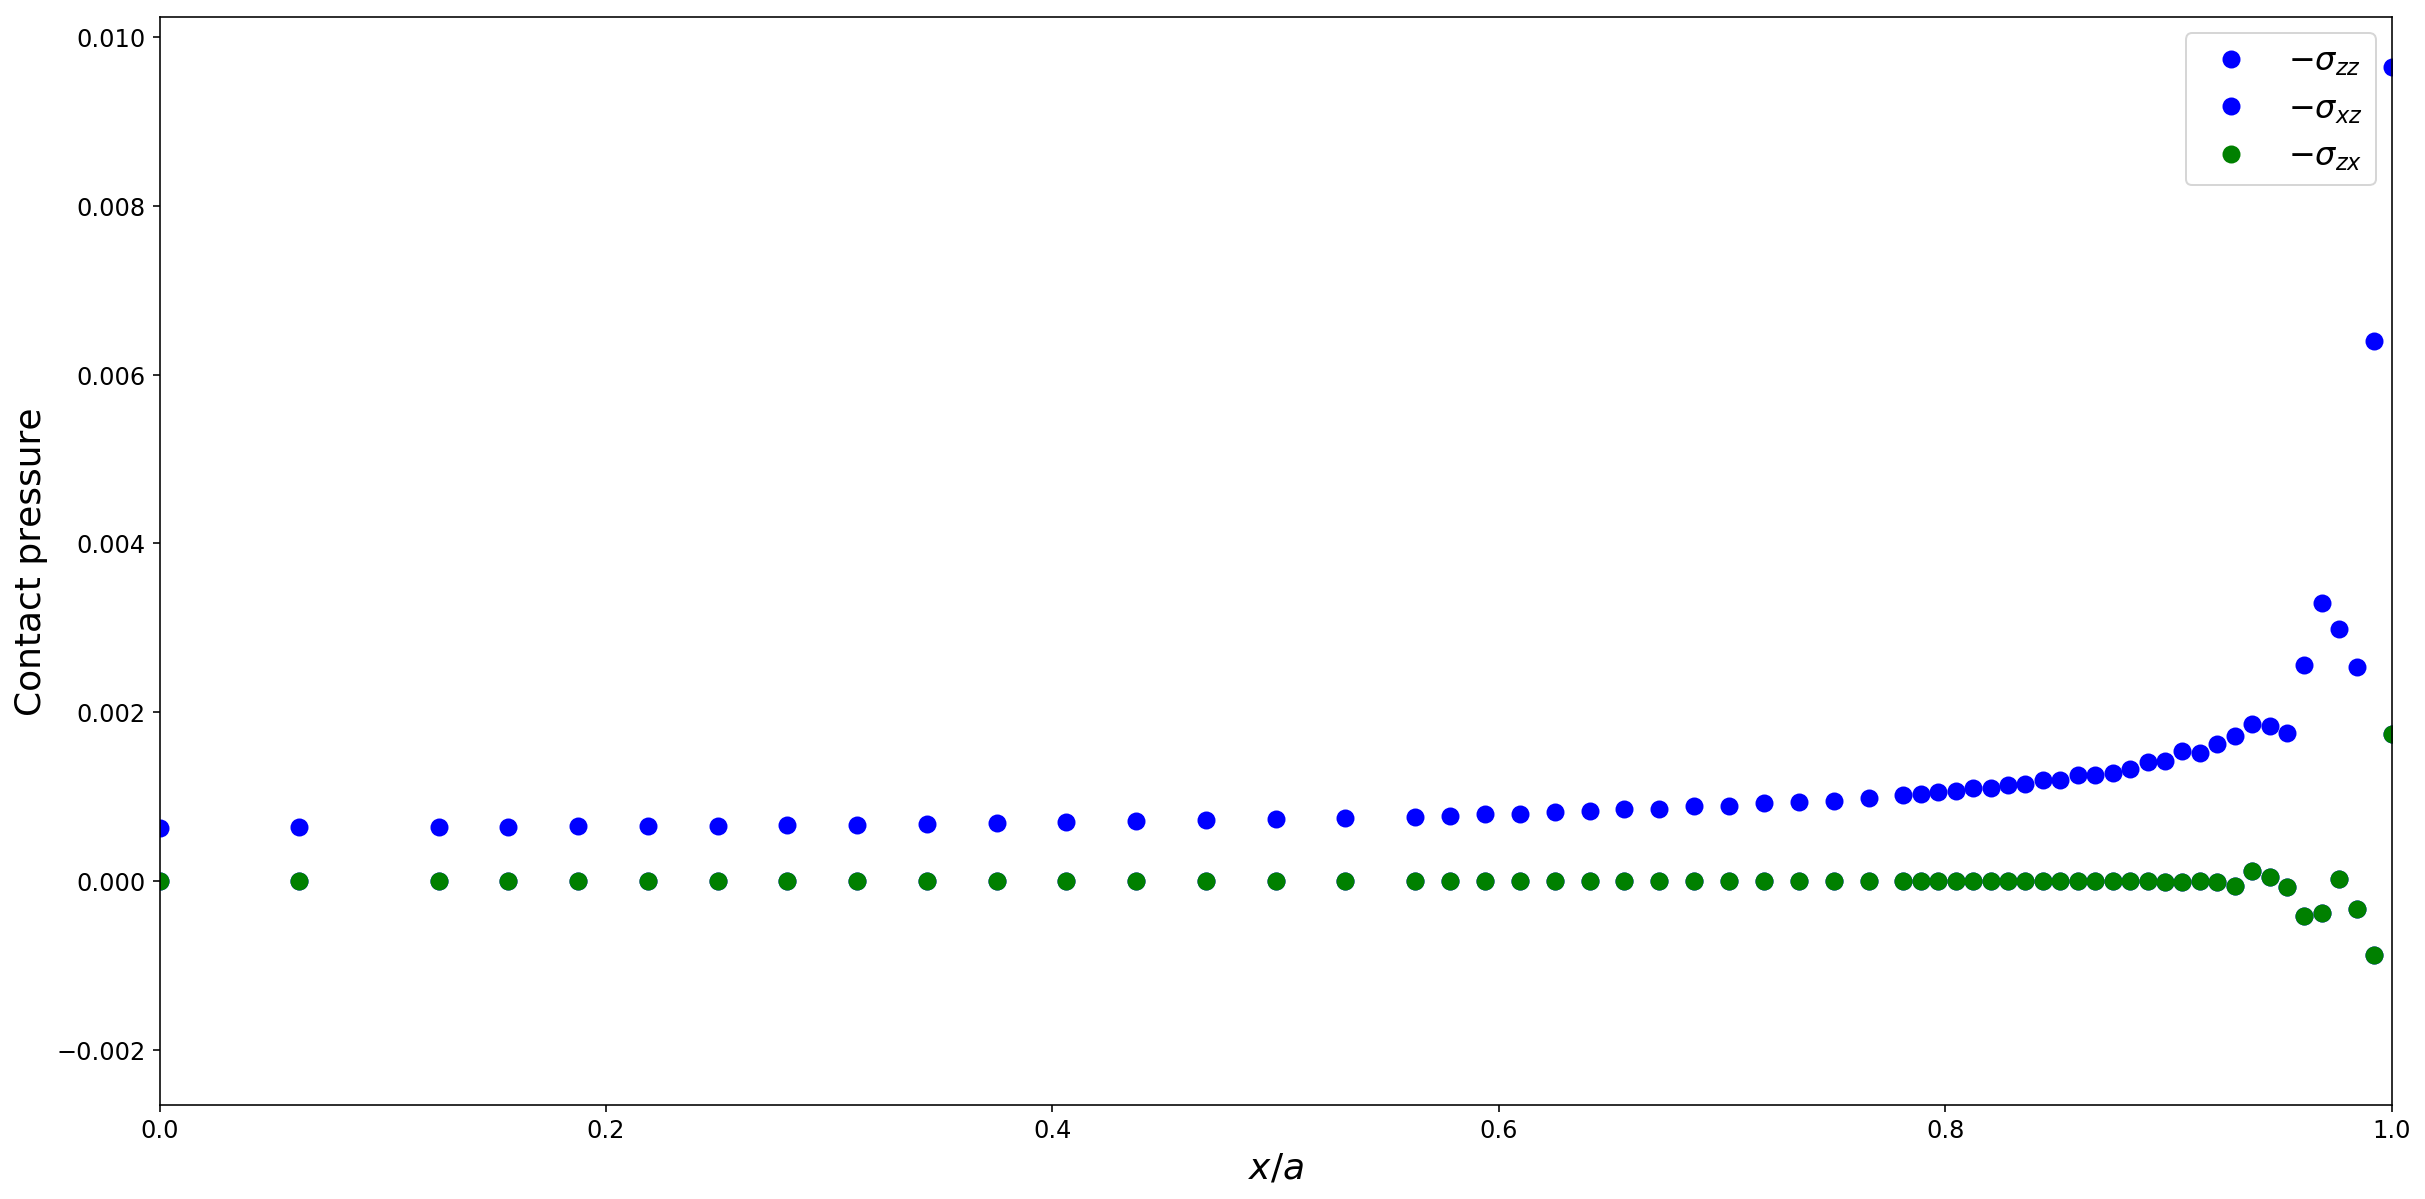

In [254]:
import matplotlib     
matplotlib.rc('xtick', labelsize=12)     
matplotlib.rc('ytick', labelsize=12)

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,10)

%config InlineBackend.figure_format = 'retina'
plt.plot(data_X, -data_sigma_zz, ls = 'none', marker = 'o', c='b', ms = 8, label = '$-\sigma_{zz}$')
plt.plot(data_X, data_sigma_xz, ls = 'none', marker = 'o', c='b', ms = 8, label = '$-\sigma_{xz}$')
plt.plot(data_X, data_sigma_zx, ls = 'none', marker = 'o', c='g', ms = 8, label = '$-\sigma_{zx}$')
#plt.plot(data_lambda_x, data_l, ls = 'none', marker = 'd', c='g', ms = 8, label = '$\lambda$')
#plt.plot(x, anal_p, c='r', lw = 1.5, label = 'Analytical solution $p(x)$')
plt.xlim(0, 1)
#plt.ylim(-0.000005, 0.000005)
plt.legend()
plt.xlabel("$x/a$", fontsize=18)
plt.ylabel("Contact pressure", fontsize=18)
plt.savefig('contact.png', dpi=300)

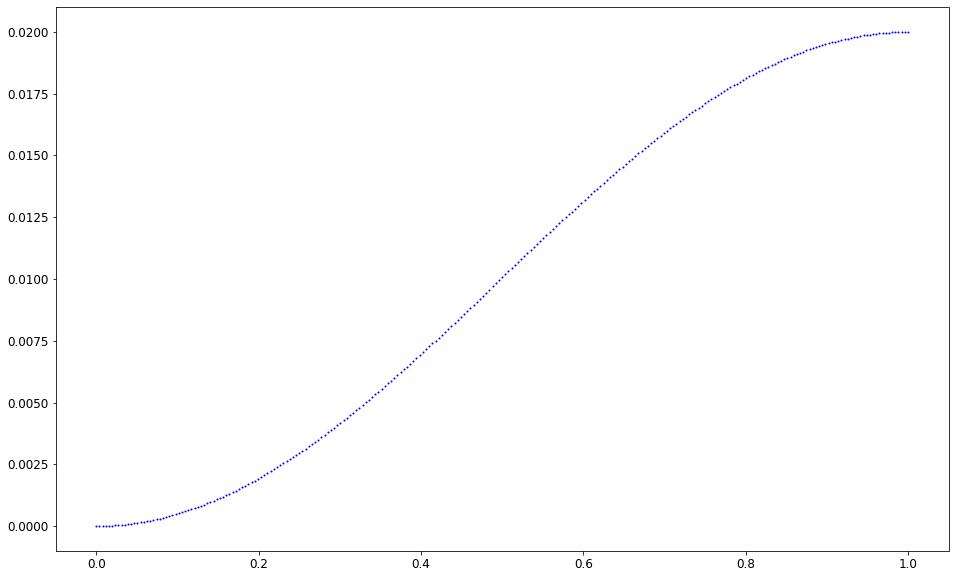

In [5]:
import matplotlib     
matplotlib.rc('xtick', labelsize=12)     
matplotlib.rc('ytick', labelsize=12)

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (16,10)

# %config InlineBackend.figure_format = 'retina'
x = get_data("test.9.csv", "MESH_NODE_POSITIONS:0")
w = get_data("test.9.csv", "SPATIAL_POSITION:2") - get_data("test.9.csv", "MESH_NODE_POSITIONS:2")
plt.plot(x, w, ls = 'none', marker = 'o', c='b', ms = 1, label = 'Numerical $w(x)$')
plt.show()
#plt.plot(data_lambda_x, data_l, ls = 'none', marker = 'd', c='g', ms = 8, label = '$\lambda$')
# plt.plot(anal_x, anal_w, c='r', lw = 1.5, label = 'Analytical $w(x)$')
# plt.xlim(0, 1.75)
# plt.ylim(-0.0044, -0.003)
# plt.legend()
# plt.xlabel("$x/a$", fontsize=18)
# plt.ylabel("Vertical displacement", fontsize=18)
# plt.savefig('contact_w.png', dpi=300)

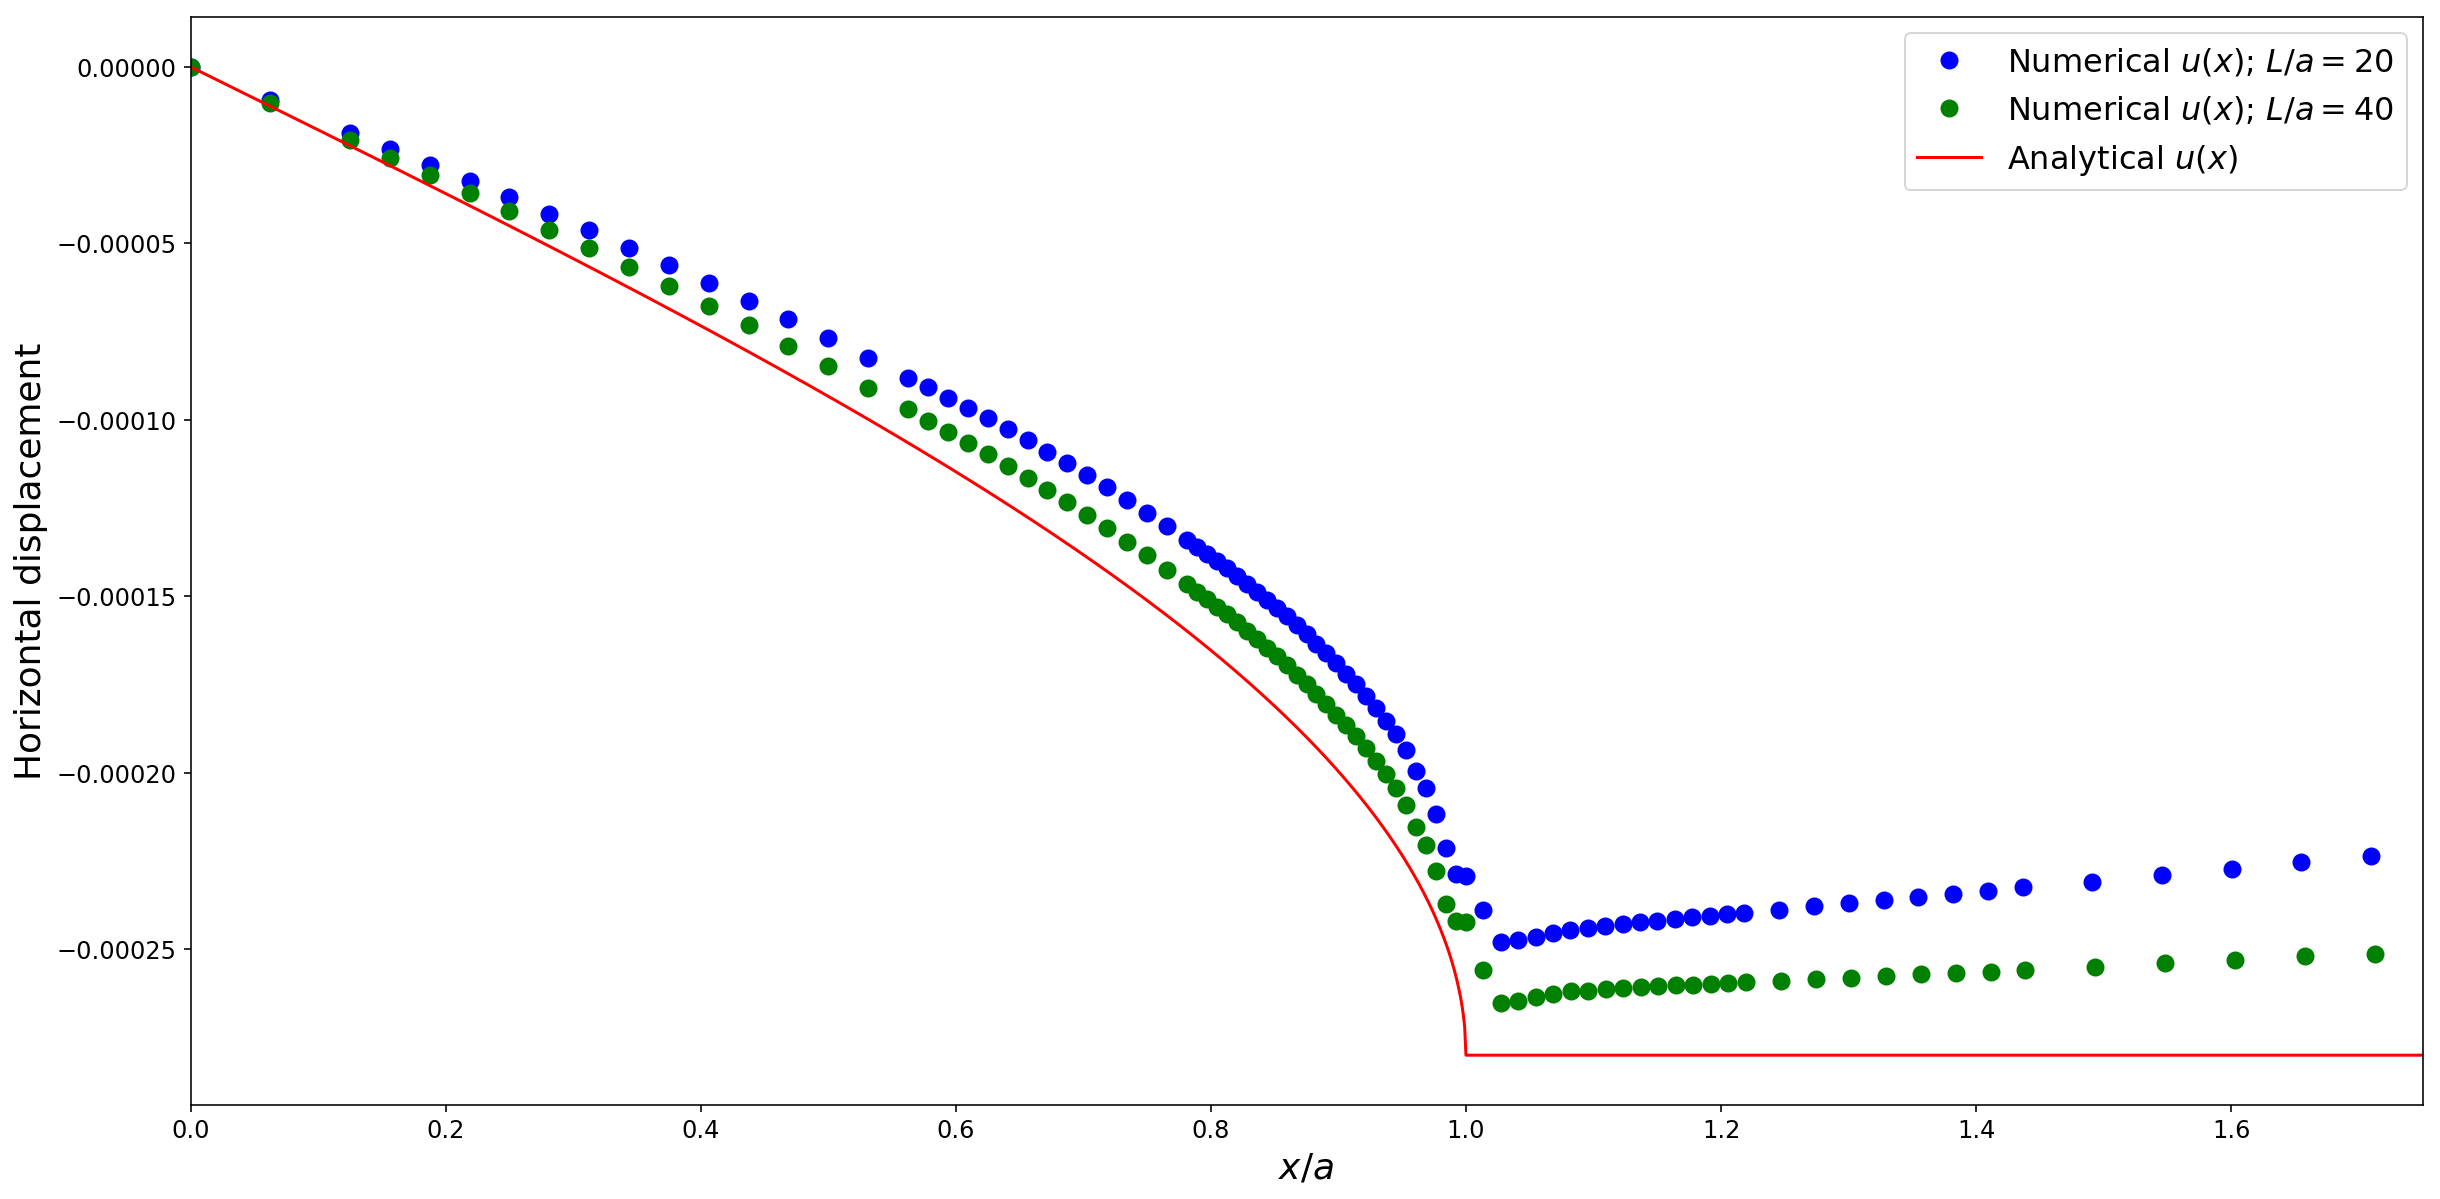

In [282]:
import matplotlib     
matplotlib.rc('xtick', labelsize=12)     
matplotlib.rc('ytick', labelsize=12)

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,10)

%config InlineBackend.figure_format = 'retina'
x = get_data("data_3.csv", "MESH_NODE_POSITIONS:0")
u = get_data("data_3.csv", "SPATIAL_POSITION:0") - get_data("data_3.csv", "MESH_NODE_POSITIONS:0")
plt.plot(x, u, ls = 'none', marker = 'o', c='b', ms = 8, label = 'Numerical $u(x)$; $L/a=20$')
x = get_data("data_4.csv", "MESH_NODE_POSITIONS:0")
u = get_data("data_4.csv", "SPATIAL_POSITION:0") - get_data("data_4.csv", "MESH_NODE_POSITIONS:0")
plt.plot(x, u, ls = 'none', marker = 'o', c='g', ms = 8, label = 'Numerical $u(x)$; $L/a=40$')
#plt.plot(data_lambda_x, data_l, ls = 'none', marker = 'd', c='g', ms = 8, label = '$\lambda$')
plt.plot(anal_x, anal_u, c='r', lw = 1.5, label = 'Analytical $u(x)$')
plt.xlim(0, 1.75)
#plt.ylim(-0.0037, -0.0024)
plt.legend()
plt.xlabel("$x/a$", fontsize=18)
plt.ylabel("Horizontal displacement", fontsize=18)
plt.savefig('contact_u.png', dpi=300)

In [242]:
0.2*1.4*0.002/2

0.00028